# **Masked prediction analysis: convolution layers only**

## Navigation

- [**Basic imports and initialization**](#Basic-imports-and-initialization)
- [**1. Alexnet**](#1.-Alexnet)
- [**2. VGG11**](#2.-VGG11)
- [**3. ResNet18**](#3.-ResNet18)

## Basic imports and initialization

$\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#1.-Alexnet)

- [Setting up templates, limiting the hardware resources, importing packages](#Setting-up-templates,-limiting-the-hardware-resources,-importing-packages)
- [Initializing common variables](#Initializing-common-variables)
- [Configuring experiments and generating corresponding sh-files](#Configuring-experiments-and-generating-corresponding-sh-files)

### Setting up templates, limiting the hardware resources, importing packages

$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$[[Next subsect.$\to$]](#Initializing-common-variables)

Select the template of config files. ```base``` is a standard one, ```slurm``` is intended for using on the clusters with slurm working manangement installed.

In [1]:
libstdcpp_path = ''

In the case of problems with loading ```libstc++.so.6```, please provide the path to the library. In any other case, just ignore the following block.

In [27]:
import ctypes

libstdcpp_path = '/mnt/bulky/pkharyuk/apd/envs/activation_sense/lib/libstdc++.so.6'
try:
    _stdcxx_lib = ctypes.cdll.LoadLibrary(libstdcpp_path)
except:
    pass

To provide easy access to modules stored in the ```../src/``` directory, we use the following workaround:

In [2]:
import sys
sys.path.append('../src/')

Next, we limit the hardware usage by setting the configuration dictionaries, maximum number of threads (and computing processes in the case of using the ```slurm```):

In [3]:
# set limitations on hardware
# fill on the template's config
import hardware_setup

mkl_num_threads = 4
hardware_setup.mkl_set_num_threads(num_threads=mkl_num_threads)

available_gpu_idxs = [0, 2, 3]
max_n_cuda = len(available_gpu_idxs)

[mkl]: set up num_threads=4/4


Then we import all necessary packages:

In [4]:
import os
import copy

import numpy as np

import sensitivity_analysis.augmentation_setting
import sensitivity_analysis.visualize
import sensitivity_analysis.preprocess_visualize

import preparation.single_unit
import preparation.visualize

import exp_assistance

import prediction.compute
import prediction.compute_separated
import prediction.crosscorr
import prediction.hca

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

### Initializing common variables

[[$\leftarrow$Prev.subsect.]](#Setting-up-templates,-limiting-the-hardware-resources,-importing-packages)$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$[[Next subsect.$\to$]](#Configuring-experiments-and-generating-corresponding-sh-files)

In [5]:
data_dirname = '../data/imagenet'

sensitivity_values_dirname = '../results/'
model_dirname = '../torch-models/'

exp_relative_path = '../experiments/'
values_fnm_base = 'imagenet_ILSVRC_values'
output_filename_suffix = 'pred_NOFCL'

results_dirname_path = '../results/'

desired_image_height = 224
desired_image_width = 224

dataset_part = 'valid'

sensitivity_values_name_list = [
    'shpv', 'si', 'siT'
]
no_aug_key = 'original'
y_true_key = 'true_labels'

alphas = [0., 0.5, 1.5]
percentiles = [0.5, 0.6, 0.7, 0.8, 0.9]
inverts = [0, 1]

augmentation_set_numbers_list = [1, 2]

linkage_hca = 'average'

cmap_cormat = 'Reds_r'
cmap_hca = 'twilight_shifted'
label_cmap_hca = 'brg_r'
max_d_label_hca = 0.025
label_background_color_hca = '#0000001A'
label_fontsize_hca = 8

figsizes_cormat = [(5*3+1, 3), (6*3+1, 4)]
figsizes_hca = [(3*4+1, 8), (3*4+1, 12)]

sensitivity_value_name_list = [
    'shpv',
    'si',
    'siT',
]

In [6]:
basic_config_dict = {
    'recompute_predictions': 1,
    'batch_size_computing': 100,
    'samples_per_class_train': 732,
    'samples_per_class_valid': 50,
    'augmentation_set_number': 3, # 1+2
    'dataset_part': dataset_part,
    'Nsamples': 50000,
    'Ninner_samples': 3,
    #'os_environment_config',
    'mkl_num_threads': mkl_num_threads,
    'data_dirname': data_dirname,
    'model_dirname': model_dirname,
    'desired_image_height': desired_image_height,
    'desired_image_width': desired_image_width,
    'use_permutation_variable': 1,
    'use_class_variable': 1,
    'use_partition_variable': 1,
    'alphas': f'"{alphas}"', #exp_assistance.convert_list2argstr(alphas),
    'percentiles': f'"{percentiles}"', #exp_assistance.convert_list2argstr(percentiles),
    'top_n_predictions': 5,
    'sensitivity_values_dirname': sensitivity_values_dirname,
    'values_fnm_base': values_fnm_base,
    'output_filename_suffix': output_filename_suffix,
}
if len(libstdcpp_path) > 0:
    basic_config_dict['libstdcpp_path'] = libstdcpp_path

### Configuring experiments and generating corresponding sh-files

[[$\leftarrow$Prev.subsect.]](#Initializing-common-variables)$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$

- [Alexnet](#Alexnet)
- [VGG11](#VGG11)
- [ResNet18](#ResNet18)


#### Alexnet

[[Back to section]](#Configuring-experiments-and-generating-corresponding-sh-files)

In [7]:
# alexnet
alexnet_network_name = 'alexnet'
alexnet_network_modules = [
    'features.2', # Conv2d + ReLU + MaxPool2d
    'features.5', # ... + Conv2d + ReLU + MaxPool2d
    'features.7', # ... + Conv2d + ReLU
    'features.9', # ... + Conv2d + ReLU
    #'features.12', # ... + Conv2d + ReLU + MaxPool2d
    'avgpool', # ... + Conv2d + ReLU + MaxPool2d + AdaptiveAvgPool
]
alexnet_network_modules = exp_assistance.convert_list2argstr(
    alexnet_network_modules
)
alexnet_classification_layer_name = 'classifier.6'

In [8]:
config_dict_alexnet = copy.deepcopy(basic_config_dict)

config_dict_alexnet['device'] = 'cuda'
config_dict_alexnet['network_name'] = alexnet_network_name
config_dict_alexnet['network_modules'] = alexnet_network_modules
config_dict_alexnet['classification_layer_name'] = alexnet_classification_layer_name
config_dict_alexnet['subset_random_state_train'] = 543
config_dict_alexnet['subset_random_state_valid'] = 765
config_dict_alexnet['torch_seed'] = 159
config_dict_alexnet['numpy_seed'] = 98
config_dict_alexnet['class_sampler_seed'] = 632
config_dict_alexnet['class_selector_seed'] = 9923
config_dict_alexnet['augpar_sampler_seeds'] = 768

In [9]:
####################################################################################
script_filename_base = f'script_exp3_{alexnet_network_name}_{output_filename_suffix}'
exp_filename = '3a_imagenet_masked_prediction.py'
exp_script_path = os.path.join(exp_relative_path, exp_filename)
for i, sensitivity_value_name in enumerate(sensitivity_values_name_list):
    config_dict_alexnet['results_dirname_path'] = os.path.join(
        results_dirname_path, alexnet_network_name, sensitivity_value_name
    )
    config_dict_alexnet['sensitivity_values_name'] = sensitivity_value_name
    if config_dict_alexnet['device'].startswith('cuda'):
        config_dict_alexnet['device'] = config_dict_alexnet['device'].split(':')[0]
        #config_dict_alexnet['device'] += f':{available_gpu_idxs[i%max_n_cuda]}'
    current_script_filename = f'{script_filename_base}_sensval={sensitivity_value_name}.sh'
    exp_assistance.build_sh_exp_files(
        config_dict_alexnet,
        current_script_filename,
        exp_script_path,
        which='base',
    );

#### VGG11

[[Back to section]](#Configuring-experiments-and-generating-corresponding-sh-files)

In [34]:
# vgg11
vgg11_network_name = 'vgg11'
vgg11_network_modules = [
    'features.2', # conv2d -> ReLU -> MaxPool2d
    'features.5', # conv2d -> ReLU -> MaxPool2d
    #'features.7', # conv2d -> ReLU ->
    'features.10', # conv2d -> ReLU -> MaxPool2d
    #'features.12', # conv2d -> ReLU ->
    'features.15', # conv2d -> ReLU -> MaxPool2d
    #'features.17', # conv2d -> ReLU ->
    #'features.20', # conv2d -> ReLU -> MaxPool2d ->
    'avgpool',
]
vgg11_network_modules = exp_assistance.convert_list2argstr(
    vgg11_network_modules
)
vgg11_classification_layer_name = 'classifier.6'

In [35]:
config_dict_vgg11 = copy.deepcopy(basic_config_dict)

config_dict_vgg11['device'] = 'cuda'
config_dict_vgg11['network_name'] = vgg11_network_name
config_dict_vgg11['network_modules'] = vgg11_network_modules
config_dict_vgg11['classification_layer_name'] = vgg11_classification_layer_name
config_dict_vgg11['subset_random_state_train'] = 245
config_dict_vgg11['subset_random_state_valid'] = 93
config_dict_vgg11['torch_seed'] = 32
config_dict_vgg11['numpy_seed'] = 3890
config_dict_vgg11['class_sampler_seed'] = 8988
config_dict_vgg11['class_selector_seed'] = 97
config_dict_vgg11['augpar_sampler_seeds'] = 21

config_dict_vgg11['batch_size_computing'] = 50
config_dict_vgg11['mkl_num_threads'] = 4

In [15]:
####################################################################################
script_filename_base = f'script_exp3_{vgg11_network_name}_{output_filename_suffix}'
exp_filename = '3a_imagenet_masked_prediction.py'
exp_script_path = os.path.join(exp_relative_path, exp_filename)
for i, sensitivity_value_name in enumerate(sensitivity_values_name_list):
    config_dict_vgg11['results_dirname_path'] = os.path.join(
        results_dirname_path, vgg11_network_name, sensitivity_value_name
    )
    config_dict_vgg11['sensitivity_values_name'] = sensitivity_value_name
    if config_dict_vgg11['device'].startswith('cuda'):
        config_dict_vgg11['device'] = config_dict_vgg11['device'].split(':')[0]
        config_dict_vgg11['device'] += f':{available_gpu_idxs[i%max_n_cuda]}'
    current_script_filename = f'{script_filename_base}_sensval={sensitivity_value_name}.sh'
    exp_assistance.build_sh_exp_files(
        config_dict_vgg11,
        current_script_filename,
        exp_script_path,
        which='base',
    );

#### ResNet18

[[Back to section]](#Configuring-experiments-and-generating-corresponding-sh-files)

In [36]:
# resnet18
resnet18_network_name = 'resnet18'
resnet18_network_modules = [
    'maxpool', # conv2d -> BN -> ReLU -> MaxPool2d
    'layer1', # Basic ResNet Block 1
    'layer2', # Basic ResNet Block 2
    'layer3', # Basic ResNet Block 3
    #'avgpool', # Basic ResNet Block 1 -> AvgPool
]
resnet18_network_modules = exp_assistance.convert_list2argstr(
    resnet18_network_modules
)
resnet18_classification_layer_name = 'fc'

In [37]:
config_dict_resnet18 = copy.deepcopy(basic_config_dict)

config_dict_resnet18['device'] = 'cuda'
config_dict_resnet18['network_name'] = resnet18_network_name
config_dict_resnet18['network_modules'] = resnet18_network_modules
config_dict_resnet18['classification_layer_name'] = resnet18_classification_layer_name
config_dict_resnet18['subset_random_state_train'] = 8
config_dict_resnet18['subset_random_state_valid'] = 9345
config_dict_resnet18['torch_seed'] = 356
config_dict_resnet18['numpy_seed'] = 901
config_dict_resnet18['class_sampler_seed'] = 6798
config_dict_resnet18['class_selector_seed'] = 3421
config_dict_resnet18['augpar_sampler_seeds'] = 4565

config_dict_resnet18['mkl_num_threads'] = 6

In [21]:
####################################################################################
script_filename_base = f'script_exp3_{resnet18_network_name}_{output_filename_suffix}'
exp_filename = '3a_imagenet_masked_prediction.py'
exp_script_path = os.path.join(exp_relative_path, exp_filename)
for i, sensitivity_value_name in enumerate(sensitivity_values_name_list):
    config_dict_resnet18['results_dirname_path'] = os.path.join(
        results_dirname_path, resnet18_network_name, sensitivity_value_name
    )
    config_dict_resnet18['sensitivity_values_name'] = sensitivity_value_name
    if config_dict_resnet18['device'].startswith('cuda'):
        config_dict_resnet18['device'] = config_dict_resnet18['device'].split(':')[0]
        #config_dict_resnet18['device'] += f':{available_gpu_idxs[i%max_n_cuda]}'
    current_script_filename = f'{script_filename_base}_sensval={sensitivity_value_name}.sh'
    exp_assistance.build_sh_exp_files(
        config_dict_resnet18,
        current_script_filename,
        exp_script_path,
        which='base',
    );

## 1. Alexnet

[[$\leftarrow$ Prev.part]](#Basic-imports-and-initialization) $\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#2.-VGG11)


- [1.1 Extract accuracy measurements](#1.1-Extract-accuracy-measurements)
- [1.2 Spearman correlation between original and augmented inputs (both masked)](#1.2-Spearman-correlation-between-original-and-augmented-inputs-(both-masked))
- [1.3 Hierarchical cluster analysis for augmented inputs with masked activations](#1.3-Hierarchical-cluster-analysis-for-augmented-inputs-with-masked-activations)

### 1.1 Extract accuracy measurements

$\quad$[[Back to section]](#1.-Alexnet)$\quad$[[Next subsect.$\to$]](#1.2-Spearman-correlation-between-original-and-augmented-inputs-(both-masked))

In [50]:
network_name = 'alexnet'

featured_measurements_dict = {}
featured_measurements_no_aug_input_dict = {}

for i_val, value_name in enumerate(sensitivity_value_name_list):
    print('='*80)
    print(value_name)
    print('='*80)
    results_path = os.path.join(
        results_dirname_path,
        f'{value_name}_{network_name}_{values_fnm_base}_pred_NOFCL_part={dataset_part}.hdf5'
    )
    results_top1, results_topn = prediction.compute.extract_accuracy(
        results_path,
        no_aug_key=no_aug_key,
        y_true_key=y_true_key,
        verbose=i_val == 0,
    )
    featured_measurements, featured_measurements_no_aug_input, measurements_no_mask_top_1 = (
        prediction.compute.collect_featured_measurements(
            results_top1,
            augmentation_set_numbers_list,
            alphas,
            percentiles,
            inverts,
            no_aug_key=no_aug_key,
        )
    )
    _, _, measurements_no_mask_top_n = (
        prediction.compute.collect_featured_measurements(
            results_topn,
            augmentation_set_numbers_list,
            alphas,
            percentiles,
            inverts,
            no_aug_key=no_aug_key,
        )
    )
    for aug_set_num in augmentation_set_numbers_list:
        print('Top-1 accuracy:')
        display(measurements_no_mask_top_1[aug_set_num])
        print('Top-5 accuracy:')
        display(measurements_no_mask_top_n[aug_set_num])
        
        featured_measurements_dict[aug_set_num] = featured_measurements_dict.get(aug_set_num, {})
        featured_measurements_no_aug_input_dict[aug_set_num] = featured_measurements_no_aug_input_dict.get(aug_set_num, {})
        featured_measurements_dict[aug_set_num][value_name] = featured_measurements[aug_set_num]
        featured_measurements_no_aug_input_dict[aug_set_num][value_name] = (
            featured_measurements_no_aug_input[aug_set_num]
        )


shpv
Nsamples=50000: num.classes=1000, min/mean/max samples per class=50/50.00/50
original::iaug=original top-1 acc=0.56
original::iaug=original top-5 acc=0.79
Top-1 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.395627,0.55878,0.502833,0.33952,0.451107,0.56308


Top-5 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.625247,0.78668,0.740773,0.57662,0.69266,0.78942


Top-1 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.49642,0.46198,0.469107,0.34088,0.56224,0.490033,0.55106,0.56308


Top-5 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.727527,0.698567,0.712813,0.56432,0.78998,0.724607,0.780627,0.78942


si
Nsamples=50000: num.classes=1000, min/mean/max samples per class=50/50.00/50
Top-1 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.395627,0.5588,0.502833,0.3395,0.4511,0.5631


Top-5 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.625247,0.7866,0.740753,0.57664,0.69266,0.7895


Top-1 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.496407,0.461987,0.469113,0.340893,0.56224,0.490033,0.55106,0.5631


Top-5 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.727533,0.698553,0.71282,0.564313,0.78994,0.724587,0.78062,0.7895


siT
Nsamples=50000: num.classes=1000, min/mean/max samples per class=50/50.00/50
Top-1 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.395627,0.5588,0.502833,0.3395,0.4511,0.5631


Top-5 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.625247,0.7866,0.740753,0.57664,0.69266,0.7895


Top-1 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.496407,0.461987,0.469113,0.340893,0.56224,0.490033,0.55106,0.5631


Top-5 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.727533,0.698553,0.71282,0.564313,0.78994,0.724587,0.78062,0.7895


### 1.2 Spearman correlation between original and augmented inputs (both masked)

[[$\leftarrow$Prev.subsect.]](#1.1-Extract-accuracy-measurements)$\quad$[[Back to section]](#1.-Alexnet)$\quad$[[Next subsect.$\to$]](#1.3-Hierarchical-cluster-analysis-for-augmented-inputs-with-masked-activations)

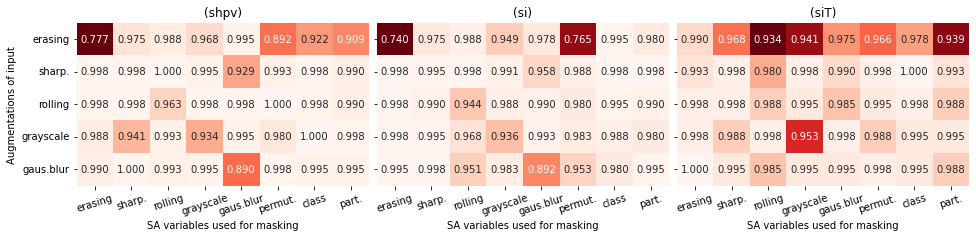

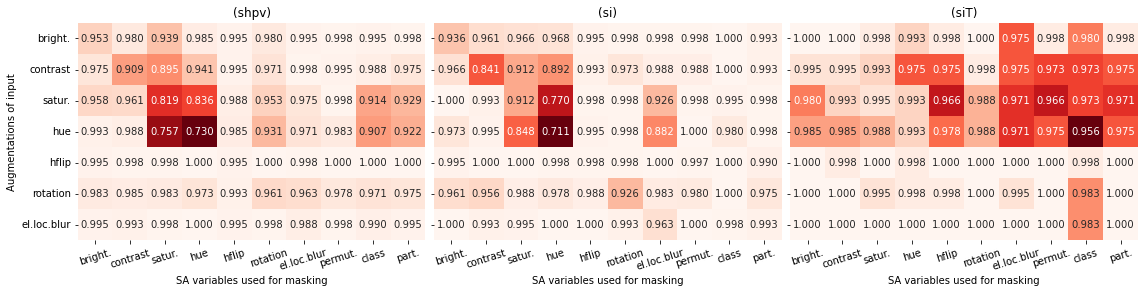

In [41]:
save_dirname = '../results/alexnet/masked_cor_patterns/'
os.makedirs(save_dirname, exist_ok=True)
save_filename_base = f'alexnet_masked_corpattern'

for i_aug, aug_set in enumerate(augmentation_set_numbers_list):
    prediction.crosscorr.plot_spearman_correlation_masked_activations_original_input_vs_augmented(
        featured_measurements_dict[aug_set],
        featured_measurements_no_aug_input_dict[aug_set],
        augmentation_set_number=aug_set,
        extract_auxilliary_names=True,
        figsize=figsizes_cormat[i_aug],
        show=True,
        cmap=cmap_cormat,
        save_path=os.path.join(save_dirname, f'{save_filename_base}_augset={aug_set}.pdf')
    )

### 1.3 Hierarchical cluster analysis for augmented inputs with masked activations

[[$\leftarrow$Prev.subsect.]](#1.2-Spearman-correlation-between-original-and-augmented-inputs-(both-masked))$\quad$[[Back to section]](#1.-Alexnet)$\quad$

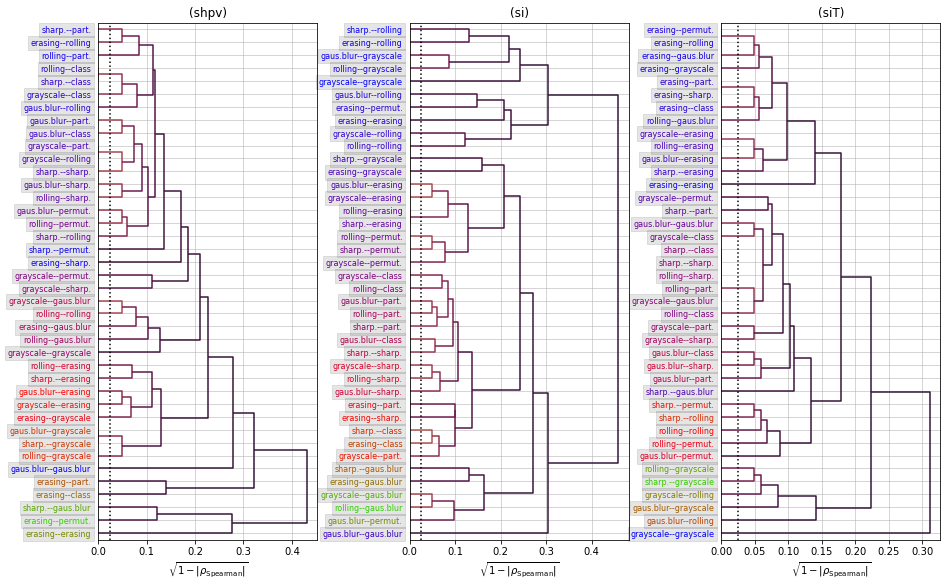

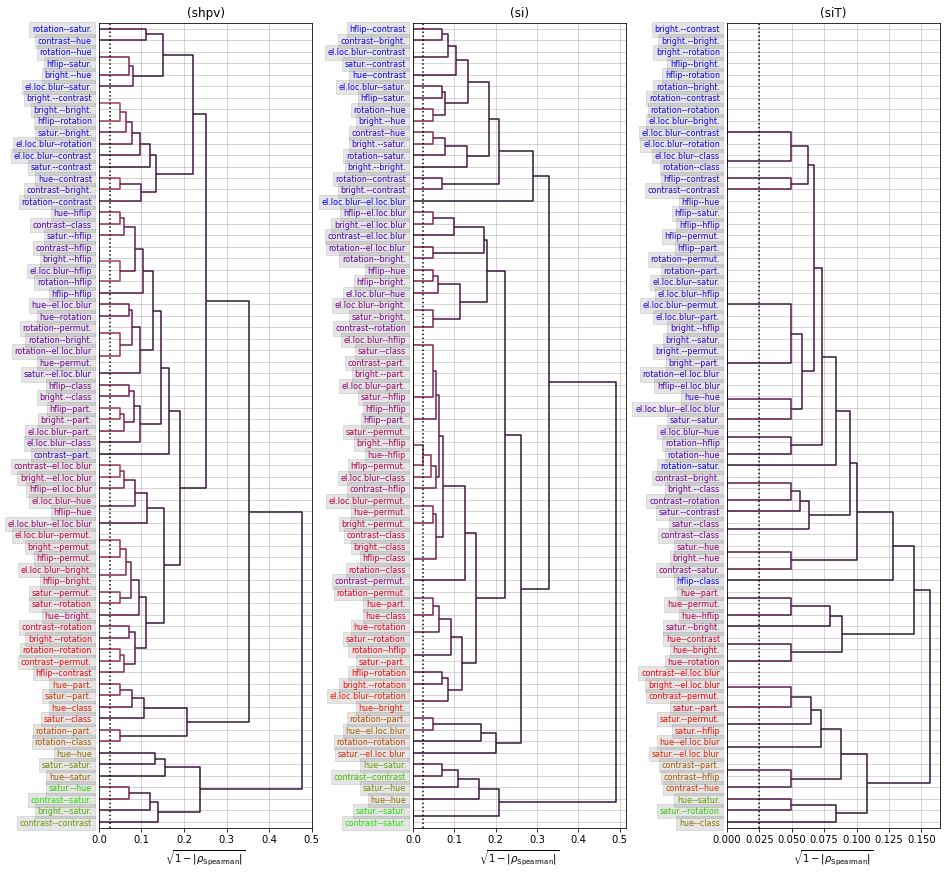

In [42]:
save_dirname = '../results/alexnet/masked_hca/'
os.makedirs(save_dirname, exist_ok=True)
save_filename_base = f'alexnet_masked_hca'

for i_aug, aug_set in enumerate(augmentation_set_numbers_list):
    prediction.hca.plot_hca_spearman_dendrogram(
        featured_measurements_dict[aug_set],
        augmentation_set_number=aug_set,
        extract_auxilliary_names=True,
        linkage=linkage_hca,
        figsize=figsizes_hca[i_aug],
        show=True,
        cmap=cmap_hca,
        label_cmap=label_cmap_hca,
        max_d_label=max_d_label_hca,
        label_background_color=label_background_color_hca,
        label_fontsize=label_fontsize_hca,
        save_path=os.path.join(save_dirname, f'{save_filename_base}_augset={aug_set}.pdf')
    )

## 2. VGG11

[[$\leftarrow$ Prev.part]](#1.-Alexnet) $\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#3.-ResNet18)


- [2.1 Extract accuracy measurements](#2.1-Extract-accuracy-measurements)
- [2.2 Spearman correlation between original and augmented inputs (both masked)](#2.2-Spearman-correlation-between-original-and-augmented-inputs-(both-masked))
- [2.3 Hierarchical cluster analysis for augmented inputs with masked activations](#2.3-Hierarchical-cluster-analysis-for-augmented-inputs-with-masked-activations)

### 2.1 Extract accuracy measurements

$\quad$[[Back to section]](#2.-VGG11)$\quad$[[Next subsect.$\to$]](#2.2-Spearman-correlation-between-original-and-augmented-inputs-(both-masked))

In [44]:
network_name = 'vgg11'

featured_measurements_dict = {}
featured_measurements_no_aug_input_dict = {}

for i_val, value_name in enumerate(sensitivity_value_name_list):
    print('='*80)
    print(value_name)
    print('='*80)
    results_path = os.path.join(
        results_dirname_path,
        f'{value_name}_{network_name}_{values_fnm_base}_pred_NOFCL_part={dataset_part}.hdf5'
    )
    results_top1, results_topn = prediction.compute.extract_accuracy(
        results_path,
        no_aug_key=no_aug_key,
        y_true_key=y_true_key,
        verbose=i_val == 0,
    )
    featured_measurements, featured_measurements_no_aug_input, measurements_no_mask_top_1 = (
        prediction.compute.collect_featured_measurements(
            results_top1,
            augmentation_set_numbers_list,
            alphas,
            percentiles,
            inverts,
            no_aug_key=no_aug_key,
        )
    )
    _, _, measurements_no_mask_top_n = (
        prediction.compute.collect_featured_measurements(
            results_topn,
            augmentation_set_numbers_list,
            alphas,
            percentiles,
            inverts,
            no_aug_key=no_aug_key,
        )
    )
    for aug_set_num in augmentation_set_numbers_list:
        print('Top-1 accuracy:')
        display(measurements_no_mask_top_1[aug_set_num])
        print('Top-5 accuracy:')
        display(measurements_no_mask_top_n[aug_set_num])
        
        featured_measurements_dict[aug_set_num] = featured_measurements_dict.get(aug_set_num, {})
        featured_measurements_no_aug_input_dict[aug_set_num] = featured_measurements_no_aug_input_dict.get(aug_set_num, {})
        featured_measurements_dict[aug_set_num][value_name] = featured_measurements[aug_set_num]
        featured_measurements_no_aug_input_dict[aug_set_num][value_name] = (
            featured_measurements_no_aug_input[aug_set_num]
        )


shpv
Nsamples=50000: num.classes=1000, min/mean/max samples per class=50/50.00/50
original::iaug=original top-1 acc=0.69
original::iaug=original top-5 acc=0.89
Top-1 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.587393,0.68622,0.651927,0.54966,0.5802,0.6888


Top-5 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.810567,0.88434,0.862,0.79256,0.810207,0.88536


Top-1 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.625313,0.596853,0.632327,0.516427,0.6879,0.60344,0.676853,0.6888


Top-5 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.835373,0.818427,0.852787,0.758073,0.88562,0.821227,0.878507,0.88536


si
Nsamples=50000: num.classes=1000, min/mean/max samples per class=50/50.00/50
Top-1 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.587387,0.68622,0.651927,0.54966,0.580187,0.6888


Top-5 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.810567,0.88434,0.862027,0.79258,0.810187,0.8854


Top-1 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.625313,0.596853,0.632327,0.516427,0.6879,0.60344,0.676853,0.6888


Top-5 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.835367,0.818427,0.852753,0.758087,0.88564,0.821227,0.878507,0.8854


siT
Nsamples=50000: num.classes=1000, min/mean/max samples per class=50/50.00/50
Top-1 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.587387,0.68622,0.651927,0.54966,0.580187,0.6888


Top-5 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.81056,0.88436,0.86202,0.79258,0.810187,0.88544


Top-1 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.625313,0.596853,0.632327,0.516427,0.6879,0.60344,0.676847,0.6888


Top-5 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.835367,0.818427,0.85276,0.758107,0.88564,0.821227,0.878507,0.88544


### 2.2 Spearman correlation between original and augmented inputs (both masked)

[[$\leftarrow$Prev.subsect.]](#2.1-Extract-accuracy-measurements)$\quad$[[Back to section]](#2.-VGG11)$\quad$[[Next subsect.$\to$]](#2.3-Hierarchical-cluster-analysis-for-augmented-inputs-with-masked-activations)

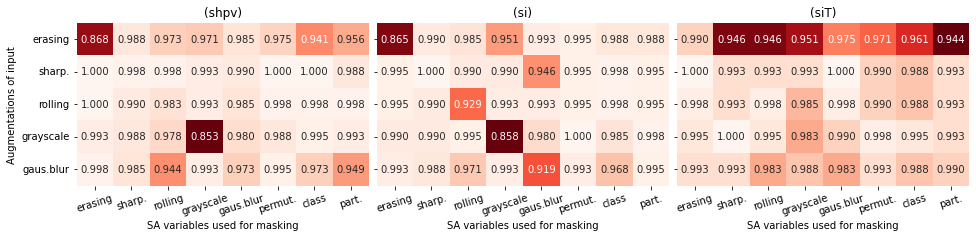

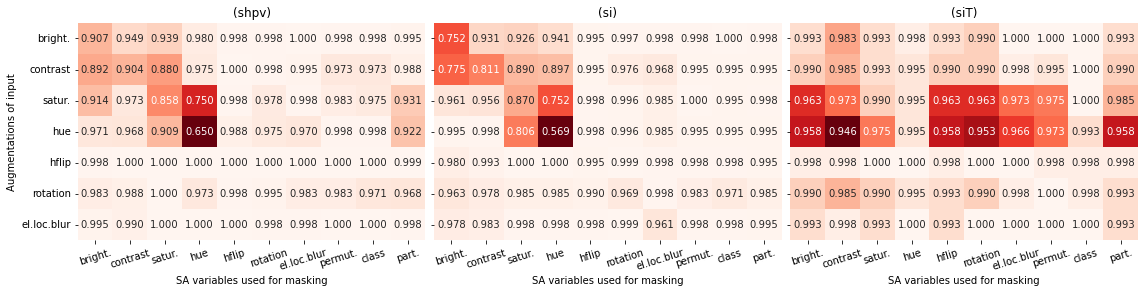

In [45]:
save_dirname = '../results/vgg11/masked_cor_patterns/'
os.makedirs(save_dirname, exist_ok=True)
save_filename_base = f'vgg11_masked_corpattern'

for i_aug, aug_set in enumerate(augmentation_set_numbers_list):
    prediction.crosscorr.plot_spearman_correlation_masked_activations_original_input_vs_augmented(
        featured_measurements_dict[aug_set],
        featured_measurements_no_aug_input_dict[aug_set],
        augmentation_set_number=aug_set,
        extract_auxilliary_names=True,
        figsize=figsizes_cormat[i_aug],
        show=True,
        cmap=cmap_cormat,
        save_path=os.path.join(save_dirname, f'{save_filename_base}_augset={aug_set}.pdf')
    );

### 2.3 Hierarchical cluster analysis for augmented inputs with masked activations

[[$\leftarrow$Prev.subsect.]](#2.2-Spearman-correlation-between-original-and-augmented-inputs-(both-masked))$\quad$[[Back to section]](#2.-VGG11)$\quad$

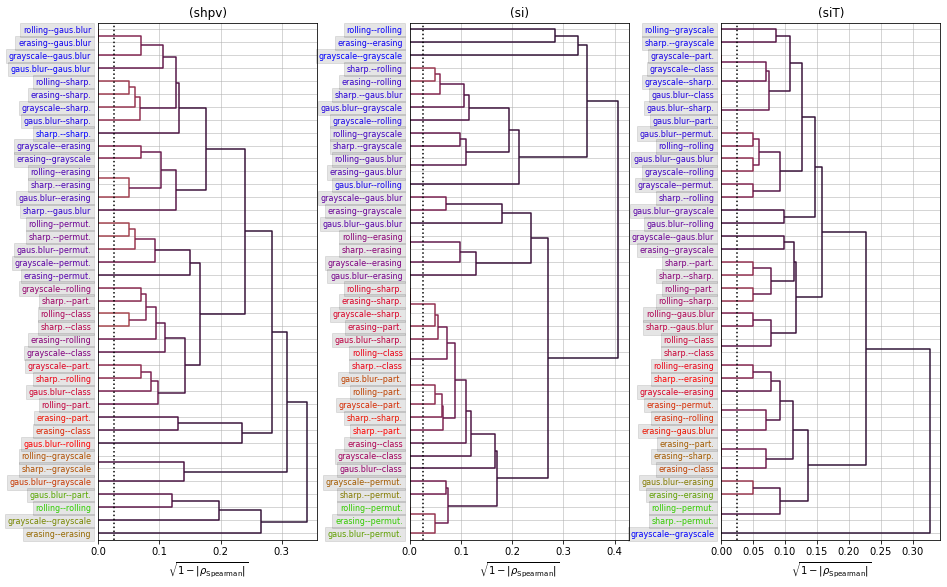

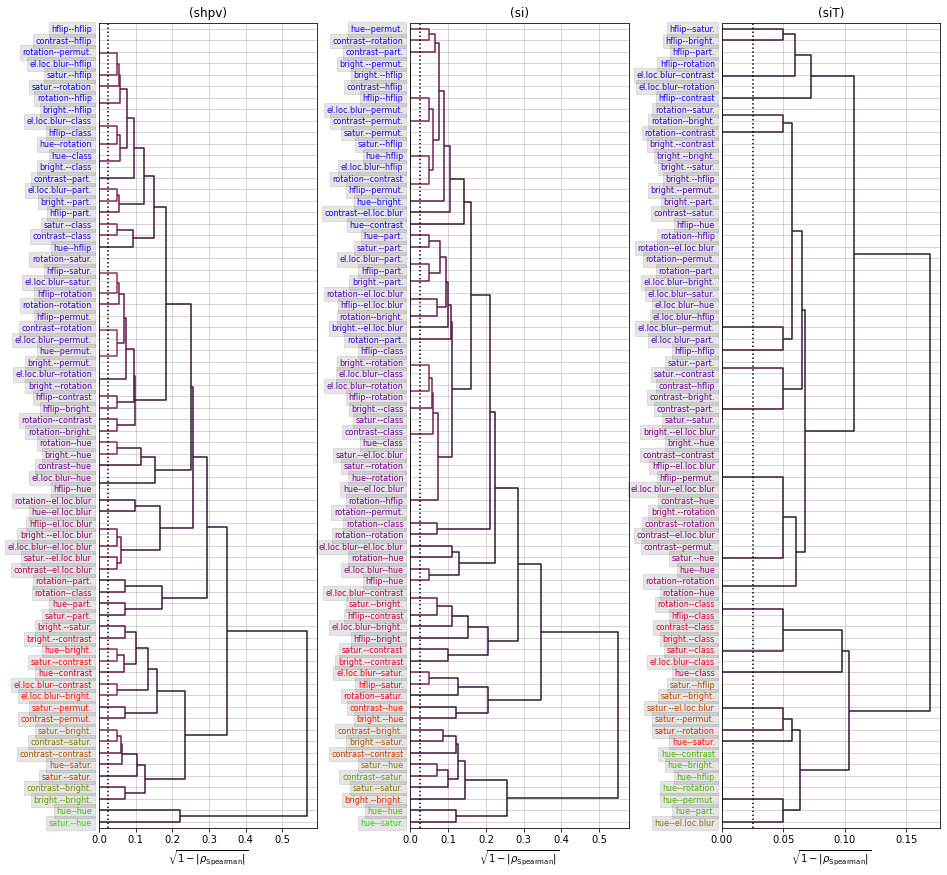

In [46]:
save_dirname = '../results/vgg11/masked_hca/'
os.makedirs(save_dirname, exist_ok=True)
save_filename_base = f'vgg11_masked_hca'

for i_aug, aug_set in enumerate(augmentation_set_numbers_list):
    prediction.hca.plot_hca_spearman_dendrogram(
        featured_measurements_dict[aug_set],
        augmentation_set_number=aug_set,
        extract_auxilliary_names=True,
        linkage=linkage_hca,
        figsize=figsizes_hca[i_aug],
        show=True,
        cmap=cmap_hca,
        label_cmap=label_cmap_hca,
        max_d_label=max_d_label_hca,
        label_background_color=label_background_color_hca,
        label_fontsize=label_fontsize_hca,
        save_path=os.path.join(save_dirname, f'{save_filename_base}_augset={aug_set}.pdf')
    )

## 3. ResNet18

[[$\leftarrow$ Prev.part]](#2.-VGG11) $\qquad$ [[Back to top]](#Navigation) $\qquad$


- [3.1 Extract accuracy measurements](#3.1-Extract-accuracy-measurements)
- [3.2 Spearman correlation between original and augmented inputs (both masked)](#3.2-Spearman-correlation-between-original-and-augmented-inputs-(both-masked))
- [3.3 Hierarchical cluster analysis for augmented inputs with masked activations](#3.3-Hierarchical-cluster-analysis-for-augmented-inputs-with-masked-activations)

### 3.1 Extract accuracy measurements

$\quad$[[Back to section]](#3.-ResNet18)$\quad$[[Next subsect.$\to$]](#3.2-Spearman-correlation-between-original-and-augmented-inputs-(both-masked))

In [47]:
network_name = 'resnet18'

featured_measurements_dict = {}
featured_measurements_no_aug_input_dict = {}

for i_val, value_name in enumerate(sensitivity_value_name_list):
    print('='*80)
    print(value_name)
    print('='*80)
    results_path = os.path.join(
        results_dirname_path,
        f'{value_name}_{network_name}_{values_fnm_base}_pred_NOFCL_part={dataset_part}.hdf5'
    )
    results_top1, results_topn = prediction.compute.extract_accuracy(
        results_path,
        no_aug_key=no_aug_key,
        y_true_key=y_true_key,
        verbose=i_val == 0,
    )
    featured_measurements, featured_measurements_no_aug_input, measurements_no_mask_top_1 = (
        prediction.compute.collect_featured_measurements(
            results_top1,
            augmentation_set_numbers_list,
            alphas,
            percentiles,
            inverts,
            no_aug_key=no_aug_key,
        )
    )
    _, _, measurements_no_mask_top_n = (
        prediction.compute.collect_featured_measurements(
            results_topn,
            augmentation_set_numbers_list,
            alphas,
            percentiles,
            inverts,
            no_aug_key=no_aug_key,
        )
    )
    for aug_set_num in augmentation_set_numbers_list:
        print('Top-1 accuracy:')
        display(measurements_no_mask_top_1[aug_set_num])
        print('Top-5 accuracy:')
        display(measurements_no_mask_top_n[aug_set_num])
        
        featured_measurements_dict[aug_set_num] = featured_measurements_dict.get(aug_set_num, {})
        featured_measurements_no_aug_input_dict[aug_set_num] = featured_measurements_no_aug_input_dict.get(aug_set_num, {})
        featured_measurements_dict[aug_set_num][value_name] = featured_measurements[aug_set_num]
        featured_measurements_no_aug_input_dict[aug_set_num][value_name] = (
            featured_measurements_no_aug_input[aug_set_num]
        )


shpv
Nsamples=50000: num.classes=1000, min/mean/max samples per class=50/50.00/50
original::iaug=original top-1 acc=0.70
original::iaug=original top-5 acc=0.89
Top-1 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.570693,0.69372,0.659387,0.55894,0.61872,0.69666


Top-5 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.793213,0.89008,0.865713,0.80038,0.836313,0.88996


Top-1 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.640227,0.61628,0.65372,0.55336,0.69618,0.62566,0.683967,0.69666


Top-5 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.847073,0.832187,0.86584,0.79136,0.89092,0.83714,0.8821,0.88996


si
Nsamples=50000: num.classes=1000, min/mean/max samples per class=50/50.00/50
Top-1 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.570693,0.69372,0.659387,0.55894,0.61872,0.69666


Top-5 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.793213,0.89008,0.865713,0.80038,0.836313,0.88996


Top-1 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.640227,0.61628,0.65372,0.55336,0.69618,0.62566,0.683967,0.69666


Top-5 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.847073,0.832187,0.86584,0.79136,0.89092,0.83714,0.8821,0.88996


siT
Nsamples=50000: num.classes=1000, min/mean/max samples per class=50/50.00/50
Top-1 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.570693,0.69372,0.659387,0.55894,0.61872,0.69666


Top-5 accuracy:


,erasing,sharpness_const,rolling,grayscaling,gaussian_blur,original
0,0.793213,0.89008,0.865713,0.80038,0.836313,0.88996


Top-1 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.640227,0.61628,0.65372,0.55336,0.69618,0.62566,0.683967,0.69666


Top-5 accuracy:


,brightness,contrast,saturation,hue,hflip,rotation,elliptic_local_blur,original
0,0.847073,0.832187,0.86584,0.79136,0.89092,0.83714,0.8821,0.88996


### 3.2 Spearman correlation between original and augmented inputs (both masked)

[[$\leftarrow$Prev.subsect.]](#3.1-Extract-accuracy-measurements)$\quad$[[Back to section]](#3.-ResNet18)$\quad$[[Next subsect.$\to$]](#3.3-Hierarchical-cluster-analysis-for-augmented-inputs-with-masked-activations)

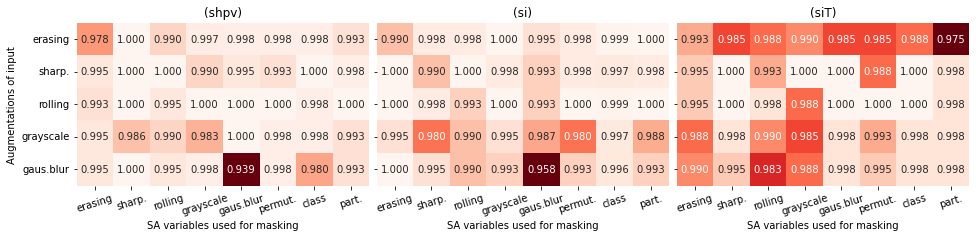

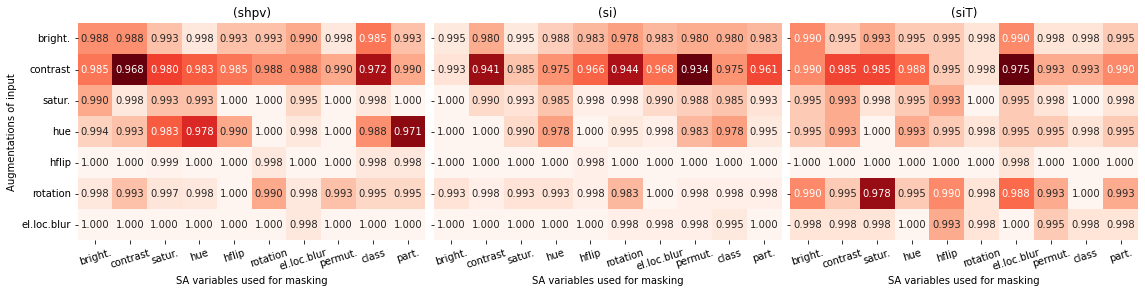

In [48]:
save_dirname = '../results/resnet18/masked_cor_patterns/'
os.makedirs(save_dirname, exist_ok=True)
save_filename_base = f'resnet18_masked_corpattern'

for i_aug, aug_set in enumerate(augmentation_set_numbers_list):
    prediction.crosscorr.plot_spearman_correlation_masked_activations_original_input_vs_augmented(
        featured_measurements_dict[aug_set],
        featured_measurements_no_aug_input_dict[aug_set],
        augmentation_set_number=aug_set,
        extract_auxilliary_names=True,
        figsize=figsizes_cormat[i_aug],
        show=True,
        cmap=cmap_cormat,
        save_path=os.path.join(save_dirname, f'{save_filename_base}_augset={aug_set}.pdf')
    );

### 3.3 Hierarchical cluster analysis for augmented inputs with masked activations

[[$\leftarrow$Prev.subsect.]](#3.2-Spearman-correlation-between-original-and-augmented-inputs-(both-masked))$\quad$[[Back to section]](#3.-ResNet18)$\quad$

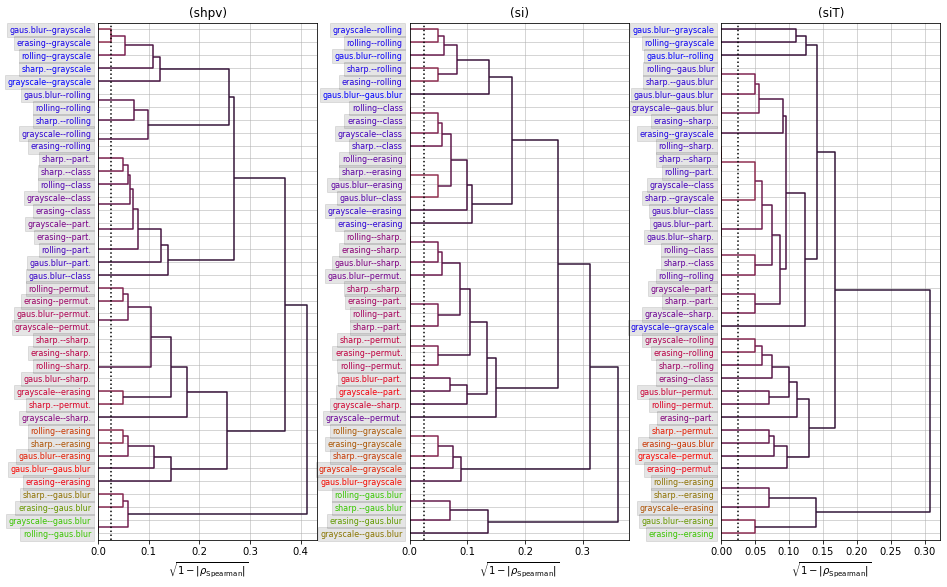

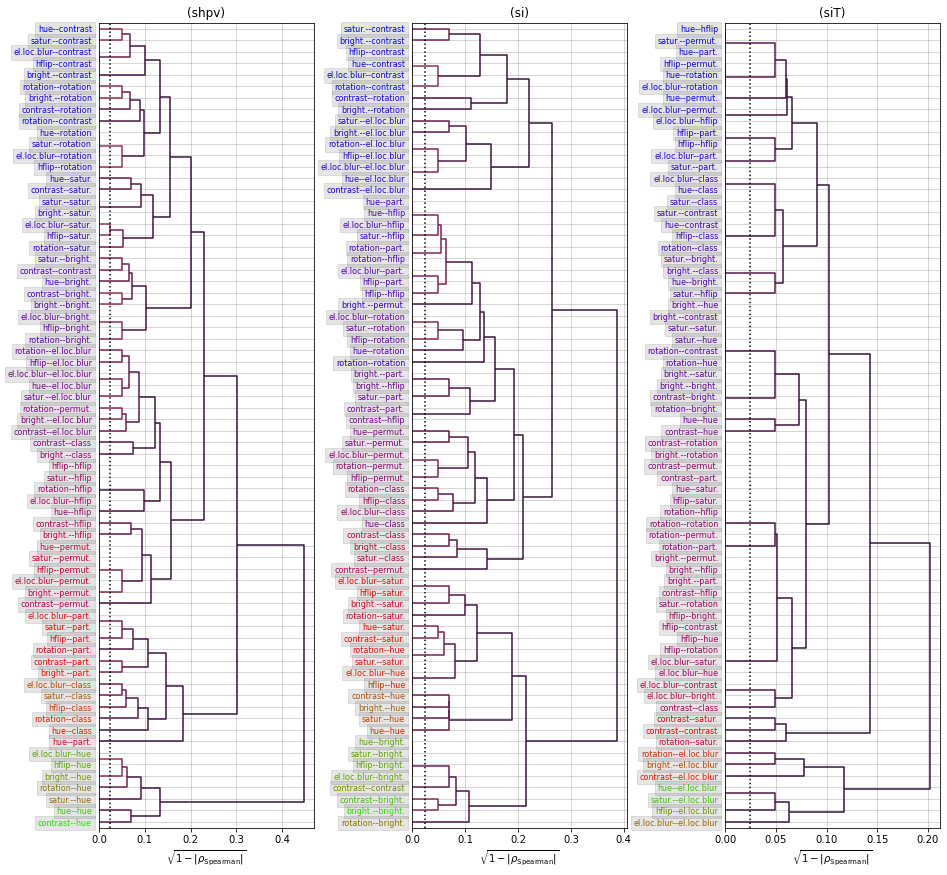

In [49]:
save_dirname = '../results/resnet18/masked_hca/'
os.makedirs(save_dirname, exist_ok=True)
save_filename_base = f'resnet18_masked_hca'

for i_aug, aug_set in enumerate(augmentation_set_numbers_list):
    prediction.hca.plot_hca_spearman_dendrogram(
        featured_measurements_dict[aug_set],
        augmentation_set_number=aug_set,
        extract_auxilliary_names=True,
        linkage=linkage_hca,
        figsize=figsizes_hca[i_aug],
        show=True,
        cmap=cmap_hca,
        label_cmap=label_cmap_hca,
        max_d_label=max_d_label_hca,
        label_background_color=label_background_color_hca,
        label_fontsize=label_fontsize_hca,
        save_path=os.path.join(save_dirname, f'{save_filename_base}_augset={aug_set}.pdf')
    )